<a href="https://colab.research.google.com/github/abrange/mit-deeplearning/blob/main/module_3/Deep_Learning_Mastering_Neural_Networks_Module_3_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 3 Assignment: MNIST Classification

Now that we have the full power of PyTorch at our disposal, we would like to classify a more concrete dataset. In particular, we are going to look at building a classifier for the [MNIST Handwritten Digits dataset](https://en.wikipedia.org/wiki/MNIST_database). This dataset contains tens of thousands of handwritten digits from 0-9 and is very commonly used for machine learning algorithm development. In this assignment, we will provide some basic dataloading code and would like you to build a deep neural network that is trained on the MNIST dataset! Feel free to reuse code you have written or seen before in previous notebooks!

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time, copy

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

First we will load in our MNIST dataset. Pytorch provides built in functions for loading popular image datasets, MNIST is one of them.

In [2]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Utility functions for plotting your results!
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                # Move tensor to CPU before plotting
                plt.plot(epochs, [t.cpu() if isinstance(t, torch.Tensor) else t for t in training_curves[phase+'_'+metric]])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        # Important! We need to flatten every datapoint
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

In [3]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)
# We will split out train dataset into train and validation!
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50_000, 10_000])
mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)


In [4]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 50000, 'val': 10000, 'test': 10000}


In [5]:
# Hint! In the Module 3 Introduction to Pytorch notebook, the Network
# we created required the input data to be of shape Nx1 where N is the number of
# features. Currently, our MNIST dataset is shape 28x28 as they are images. Use
# this code snippet as you iterate through the datapoint in your dataset to flatten
# them so it is size 784x1 and can be used with the models we designed previously!

# This loop only iterates through the "train" datapoints
# In the previous notebook
phases = ["train", "val", "test"]
for phase in phases:
  count = 0
  for inputs, labels in dataloaders[phase]:
    #print(inputs.shape, labels.shape)
    count += 1

    # This flattens every every batch to the correct size!
    before = inputs.shape
    inputs = inputs.view(inputs.shape[0],-1)
    print("before", before, "after", inputs.shape)
    break

  print("end count", phase, count)

before torch.Size([100, 1, 28, 28]) after torch.Size([100, 784])
end count train 1
before torch.Size([100, 1, 28, 28]) after torch.Size([100, 784])
end count val 1
before torch.Size([100, 1, 28, 28]) after torch.Size([100, 784])
end count test 1


In [6]:
print(inputs.shape)
print(inputs)

torch.Size([100, 784])
tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])


In [6]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # This ensures all of our datapoints are flattened
                # before feeding them to our model
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (based on validation)
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

# Two-hidden-Layer Training and error visualization


In [7]:
# Create a Model as Python class for a Mulity Category Classifier that inherit from pytorch.nn.Model

# Simple two-hidden-layer classification model
class SimpleClassifier2Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(SimpleClassifier2Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [12]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

FEATURE_LEN = 784
# hyperparameters

# model architecture
input_size = FEATURE_LEN
hidden_size1 = 512
hidden_size2 = 256
num_classes = 10

# external training parameters
batch_size = 10
learning_rate = 0.001
num_epochs = 30

In [13]:
# Your code here #
# I will try first with a 2 hidden-layers models

# Print the models
two_layer_model = SimpleClassifier2Layer(input_size, hidden_size1, hidden_size2, num_classes).to(device)
print(two_layer_model)

model = two_layer_model

# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(two_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# Make sure you save the training curves along the way for visualization afterwards!
two_layer_model, training_curves_two_layer = train_model(
    model,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs
  )
# Training complete in 5m 5s
# Best val Acc: 0.973300 at epoch 18, using 128 x 64

# Training complete in 5m 29s
# Best val Acc: 0.978200 at epoch 18, USING 256 * 128

SimpleClassifier2Layer(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

Epoch 1/30
----------
train Loss: 0.3555 Acc: 0.8907
val   Loss: 0.1903 Acc: 0.9417
test  Loss: 0.1827 Acc: 0.9441

Epoch 2/30
----------
train Loss: 0.1534 Acc: 0.9522
val   Loss: 0.1276 Acc: 0.9627
test  Loss: 0.1292 Acc: 0.9570

Epoch 3/30
----------
train Loss: 0.1071 Acc: 0.9664
val   Loss: 0.1087 Acc: 0.9665
test  Loss: 0.1131 Acc: 0.9634

Epoch 4/30
----------
train Loss: 0.0820 Acc: 0.9742
val   Loss: 0.0973 Acc: 0.9686
test  Loss: 0.1024 Acc: 0.9683

Epoch 5/30
----------
train Loss: 0.0651 Acc: 0.9793
val   Loss: 0.0874 Acc: 0.9745
test  Loss: 0.0910 Acc: 0.9715

Epoch 6/30
----------
train Loss: 0.0528 Acc: 0.9825
val   Loss: 0.0970 Acc: 0.9727
test  Loss: 0.1021 Acc: 0.9703

Epoch 7/30
----------
train Loss

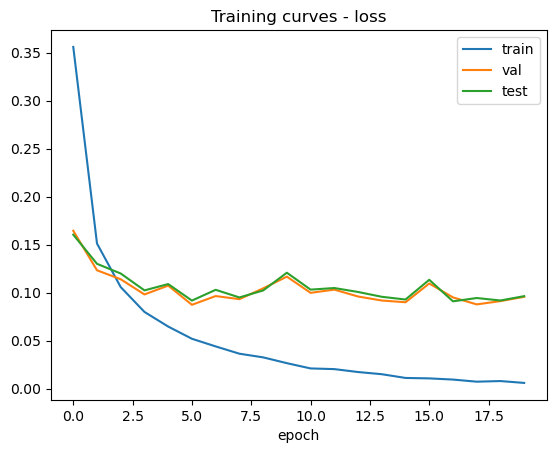

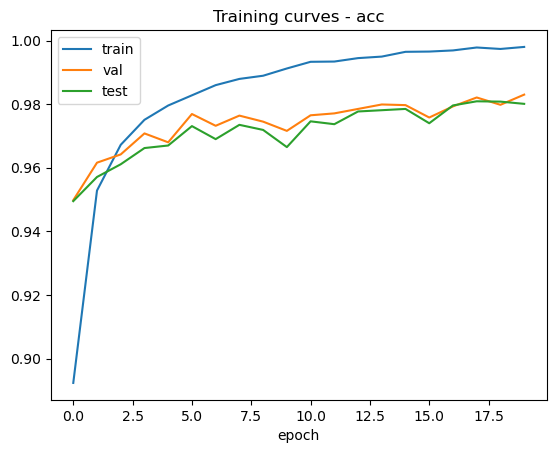

In [10]:
plot_training_curves(training_curves_two_layer, phases=['train', 'val', 'test'])

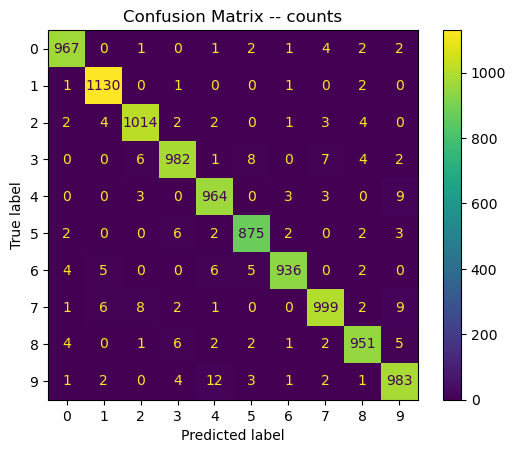

In [11]:
res = plot_cm(two_layer_model, device, dataloaders, phase='test')

## 3 Layers

In [14]:
# Simple three-hidden-layer classification model
class SimpleClassifier3Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(SimpleClassifier3Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [17]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

FEATURE_LEN = 784
# hyperparameters

# model architecture
input_size = FEATURE_LEN
hidden_size1 = 512
hidden_size2 = 256
hidden_size3 = 128
num_classes = 10

# external training parameters
batch_size = 10
learning_rate = 0.001
num_epochs = 20

# Results:
# Training complete in 4m 7s
# Best val Acc: 0.972000 at epoch 11

In [18]:
three_layer_model = SimpleClassifier3Layer(
    input_size,
    hidden_size1,
    hidden_size2,
    hidden_size3,
    num_classes).to(device)
print(three_layer_model)

model = three_layer_model

# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
# By adding a weight_decay term to the optimizer, we are including L2 Regularization!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)
# Optimizer without a Decay.
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# Make sure you save the training curves along the way for visualization afterwards!
print("num_classed:", num_classes)
print("device:", device)
three_layer_model, training_curves_three_layer = train_model(
    model,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs
  )

SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
num_classed: 10
device: cpu

Epoch 1/20
----------
train Loss: 0.4262 Acc: 0.8688
val   Loss: 0.2431 Acc: 0.9246
test  Loss: 0.2366 Acc: 0.9246

Epoch 2/20
----------
train Loss: 0.2356 Acc: 0.9295
val   Loss: 0.2030 Acc: 0.9368
test  Loss: 0.1923 Acc: 0.9394

Epoch 3/20
----------
train Loss: 0.1968 Acc: 0.9412
val   Loss: 0.2032 Acc: 0.9361
test  Loss: 0.1880 Acc: 0.9401

Epoch 4/20
----------
train Loss: 0.1771 Acc: 0.9479
val   Loss: 0.1883 Acc: 0.9395
test  Loss: 0.1744 Acc: 0.9462

Epoch 5/20
----------
train Loss: 0.1612 Acc: 0.9531
val   Loss: 0.1579 Acc: 0.9524
test  Loss: 0.1498 Acc: 0.9553

Epoch 6/20
----------
train Loss: 0.1478 A

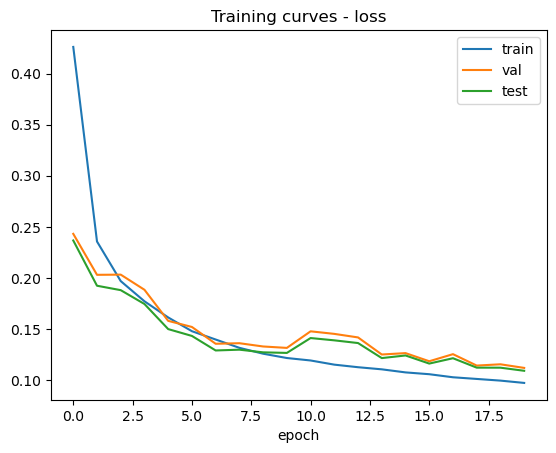

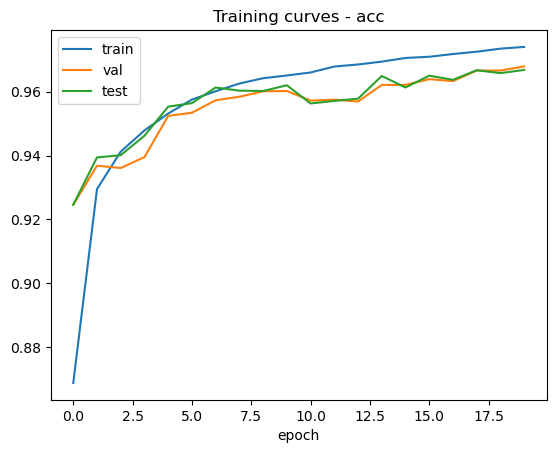

In [19]:
plot_training_curves(training_curves_three_layer, phases=['train', 'val', 'test'])

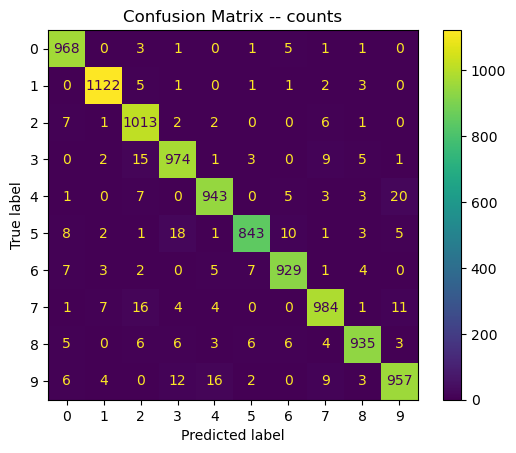

In [20]:
res = plot_cm(three_layer_model, device, dataloaders, phase='test')

# 3 Layers with Dropout

In [21]:
# Simple three-hidden-layer classification model with dropout
class SimpleClassifier3LayerDropout(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout):
        super(SimpleClassifier3LayerDropout, self).__init__()
        self.dropout = nn.Dropout(dropout) # dropout rate
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [22]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
# hyperparameters

# model architecture
input_size = FEATURE_LEN
hidden_size1 = 512
hidden_size2 = 128
hidden_size3 = 128
num_classes = 10
dropout = .5

# external training parameters
batch_size = 10
learning_rate = 0.001
num_epochs = 20

device: cpu


In [23]:
# Reset the model with dropout
print(num_classes)
print(device)

three_layer_encoded_l2_dropout_model = SimpleClassifier3LayerDropout(
    input_size,
    hidden_size1,
    hidden_size2,
    hidden_size3,
    num_classes,
    dropout).to(device)
print("MODEL:", three_layer_encoded_l2_dropout_model)


# loss and optimizer
criterion = nn.CrossEntropyLoss()
# By adding a weight_decay term to the optimizer, we are including L2 Regularization!
optimizer = torch.optim.Adam(three_layer_encoded_l2_dropout_model.parameters(), lr=learning_rate, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

three_layer_encoded_l2_dropout_model, training_curves_three_layer_encoded_l2_dropout = train_model(
    three_layer_encoded_l2_dropout_model,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs
)


10
cpu
MODEL: SimpleClassifier3LayerDropout(
  (dropout): Dropout(p=0.5, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)

Epoch 1/20
----------
train Loss: 0.8427 Acc: 0.7236
val   Loss: 0.3515 Acc: 0.9001
test  Loss: 0.3377 Acc: 0.9017

Epoch 2/20
----------
train Loss: 0.5133 Acc: 0.8487
val   Loss: 0.2897 Acc: 0.9184
test  Loss: 0.2812 Acc: 0.9163

Epoch 3/20
----------
train Loss: 0.4748 Acc: 0.8622
val   Loss: 0.2663 Acc: 0.9210
test  Loss: 0.2572 Acc: 0.9218

Epoch 4/20
----------
train Loss: 0.4598 Acc: 0.8687
val   Loss: 0.2736 Acc: 0.9189
test  Loss: 0.2646 Acc: 0.9215

Epoch

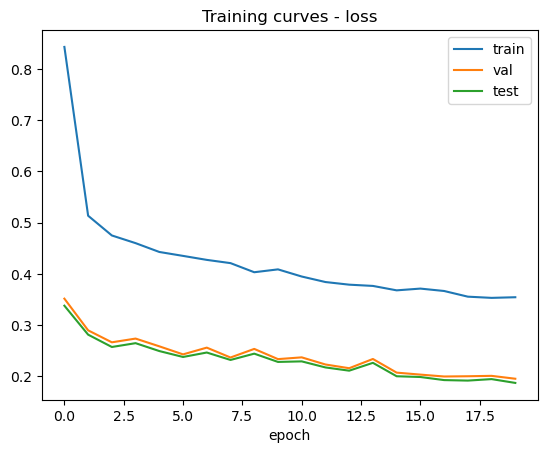

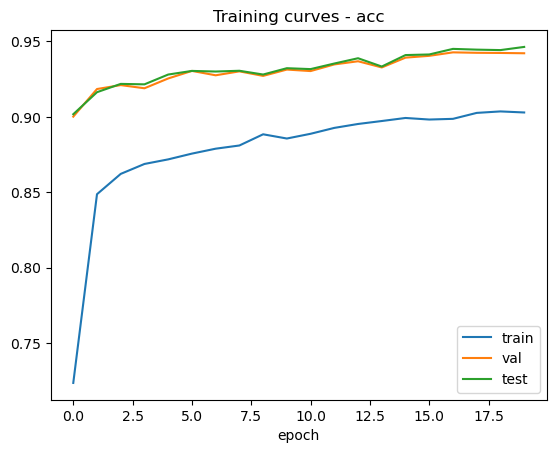

In [24]:
plot_training_curves(training_curves_three_layer_encoded_l2_dropout, phases=['train', 'val', 'test'])

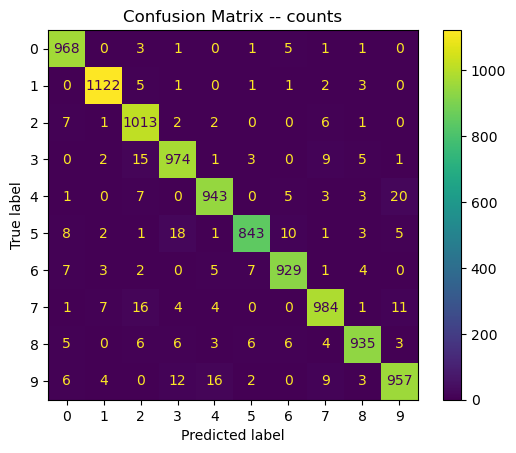

In [25]:
res = plot_cm(three_layer_model, device, dataloaders, phase='test')

# Final Model Section / Submission

I have tried mainly three different architectures to generate this multi-classifier for MNIST handwritten digits.

* Model 1: 2 hidden layers (512 * 256 neurons in hidden layers)
* Model 2: 3 hidden layers (512 * 256 neurons in hidden layers, with regularization)
* Model 3: 3 hidden layers with dropout

---


Of all the 3, the one that performed better based on Accuracy, was **Model 1**, with 2 hidden layers and no regularization or dropout

> **Training complete in 2m 14s**

> **Best val Acc: 0.984900 at epoch 28**

